The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [163]:
import pandas as pd
import numpy as np
import scipy as sp



import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL
from functions import *

Now using different method to find best xgboost version

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in six pieces. 

In [164]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')
real_power5=pd.read_csv(path+"Realisierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')
real_power6=pd.read_csv(path+"Realisierter_Stromverbrauch_202401030000_202403112359_Viertelstunde.csv",delimiter=';')

Processing them. 

In [165]:
print(real_power5.columns)

Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen'],
      dtype='object')


In [166]:
processed1=prepare_input(real_power1,old=True,str_convert=False)
processed2=prepare_input(real_power2,old=True,str_convert=False)
processed3=prepare_input(real_power3,old=True,str_convert=False)
processed4=prepare_input(real_power4,old=True,str_convert=False)
processed5=prepare_input(real_power5,old=False,str_convert=True)
processed6=prepare_input(real_power6,old=False,str_convert=True)

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:561: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/

Combine them and plot for checking. 

dimensions of the data are (322322, 5)


Text(0, 0.5, 'total power [GW]')

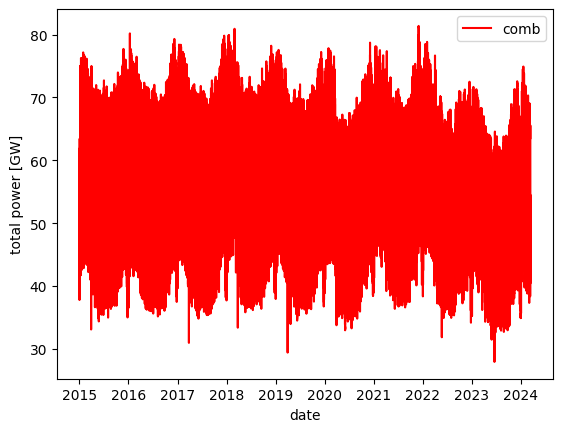

In [167]:
#date_time is set to index
processed1=processed1.set_index('date_time')
processed2=processed2.set_index('date_time')
processed3=processed3.set_index('date_time')
processed4=processed4.set_index('date_time')
processed5=processed5.set_index('date_time')
processed6=processed6.set_index('date_time')

#combining with concat
comb_real_power=pd.concat([processed4,processed3,processed2,processed1,processed5,processed6])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

Including new worked. 

In [168]:
#freeing space 
real_power1=0
real_power2=0
real_power3=0
real_power4=0
real_power5=0
real_power6=0
processed1=0
processed2=0
processed3=0
processed4=0
processed5=0
processed6=0

No official predictions for now. 

In [169]:
#pred_power1=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
#pred_power4=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201501010000_201611302359_Viertelstunde.csv",delimiter=';')
#pred_power3=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201612010000_201811302359_Viertelstunde.csv",delimiter=';')
#pred_power2=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201812010000_202011302359_Viertelstunde.csv",delimiter=';')
#pred_power5=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

In [170]:
print(comb_real_power.columns)

Index(['date_time', 'total_power', 'frac_day', 'frac_week', 'frac_year'], dtype='object')


In [171]:
from dateutil.easter import *

Create date in full delta days relative to previous March 1. That get the normal holidays right also in leap years and is close to the average year. Then also create delta days to eastre in that year thatgets the easter related holidays right right (can be between Februar and June, but most are unaffected). 

In [172]:
print(easter(2024))
print(comb_real_power.date_time.dt.year)
comb_real_power['year']=comb_real_power.date_time.dt.year.astype(int)
comb_real_power['month']=comb_real_power.date_time.dt.month.astype(int)
print(comb_real_power.dtypes)
print(easter(comb_real_power.year.iloc[0]))
comb_real_power['delta_easter']=0
#days from first march of the year, gest holidayts right given leap years
comb_real_power['delta_march']=0
for i in range(comb_real_power.shape[0]):
     comb_real_power['delta_easter'].iloc[i]=(comb_real_power['date_time'].iloc[i]-pd.to_datetime(easter(comb_real_power.year.iloc[i]))).days
     if comb_real_power.month.iloc[i]<2.5:
         comb_real_power['delta_march'].iloc[i]=(comb_real_power['date_time'].iloc[i]-datetime(comb_real_power['year'].iloc[i]-1,3,1)).days
     else:
         comb_real_power['delta_march'].iloc[i]=(comb_real_power['date_time'].iloc[i]-datetime(comb_real_power['year'].iloc[i],3,1)).days        
print(comb_real_power)
print(comb_real_power.dtypes)

2024-03-31
0         2015
1         2015
2         2015
3         2015
4         2015
          ... 
322317    2024
322318    2024
322319    2024
322320    2024
322321    2024
Name: date_time, Length: 322322, dtype: int64
date_time      datetime64[ns]
total_power           float64
frac_day              float64
frac_week             float64
frac_year             float64
year                    int64
month                   int64
dtype: object
2015-04-05


/tmp/ipykernel_3320/1941346688.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_real_power['delta_easter'].iloc[i]=(comb_real_power['date_time'].iloc[i]-pd.to_datetime(easter(comb_real_power.year.iloc[i]))).days
/tmp/ipykernel_3320/1941346688.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_real_power['delta_march'].iloc[i]=(comb_real_power['date_time'].iloc[i]-datetime(comb_real_power['year'].iloc[i]-1,3,1)).days
/tmp/ipykernel_3320/1941346688.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

                 date_time  total_power  frac_day  frac_week  frac_year  year  \
0      2015-01-01 00:00:00     11.21000  0.000000   0.000000   0.000000  2015   
1      2015-01-01 00:15:00     11.11900  0.010417   0.001488   0.000029  2015   
2      2015-01-01 00:30:00     11.14500  0.020833   0.002976   0.000057  2015   
3      2015-01-01 00:45:00     11.12700  0.031250   0.004464   0.000086  2015   
4      2015-01-01 01:00:00     11.01000  0.041667   0.005952   0.000114  2015   
...                    ...          ...       ...        ...        ...   ...   
322317 2024-03-11 11:15:00     16.37900  0.468750   0.638393   0.192248  2024   
322318 2024-03-11 11:30:00     16.34550  0.479167   0.639881   0.192277  2024   
322319 2024-03-11 11:45:00     16.24175  0.489583   0.641369   0.192305  2024   
322320 2024-03-11 12:00:00     15.99775  0.500000   0.642857   0.192334  2024   
322321 2024-03-11 12:15:00     15.88125  0.510417   0.644345   0.192363  2024   

        month  delta_easter

Test them. 

In [176]:
print(comb_real_power.delta_easter.value_counts())
print(comb_real_power.delta_march.value_counts())

-24     960
-58     960
-41     960
-42     960
-44     960
       ... 
-110     96
-109     96
-108     96
-107     96
 279     96
Name: delta_easter, Length: 390, dtype: int64
306    960
350    960
356    960
355    960
354    960
      ... 
27     860
25     856
26     856
28     856
365    288
Name: delta_march, Length: 366, dtype: int64


No gap prediction for now. 

In [177]:
#first now then to predict, here the 96 will be varies to get for many periods 
ser=series_to_supervised(comb_real_power.total_power,1,40)
print(ser.shape,ser[0:10,0:10])

(322281, 2) [[11.21  10.971]
 [11.119 11.157]
 [11.145 11.334]
 [11.127 11.587]
 [11.01  11.74 ]
 [10.923 11.888]
 [10.817 11.992]
 [10.705 12.072]
 [10.65  12.162]
 [10.547 12.175]]


Make to data frame

In [197]:
df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
df_ser.loc[:,'frac_day']=comb_real_power.loc[0:df_ser.shape[0],'frac_day']
df_ser.loc[:,'frac_week']=comb_real_power.loc[0:df_ser.shape[0],'frac_week']
df_ser.loc[:,'frac_year']=comb_real_power.loc[0:df_ser.shape[0],'frac_year']
df_ser.loc[:,'delta_march']=comb_real_power.loc[0:df_ser.shape[0],'delta_march']
df_ser.loc[:,'delta_easter']=comb_real_power.loc[0:df_ser.shape[0],'delta_easter']
df_ser.loc[:,'date_time']=comb_real_power.loc[0:df_ser.shape[0],'date_time']

In [199]:
print(df_ser.columns)
frac1=int(df_ser.shape[0]*0.8)
print(frac1)
ser_train=df_ser.iloc[:frac1,:]
ser_test=df_ser.iloc[frac1:,:]
x_train=ser_train.loc[:,['now','frac_day', 'frac_week']]
y_train=ser_train.loc[:,'to_predict']
x_test=ser_test.loc[:,['now','frac_day', 'frac_week']]
y_test=ser_test.loc[:,'to_predict']

Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year',
       'delta_march', 'delta_easter', 'date_time'],
      dtype='object')
257824


In [180]:
model = XGBRegressor(n_estimators=300)
eval_set = [(x_test, y_test)]

In [181]:
model.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:8.94486
[1]	validation_0-rmse:6.15499
[2]	validation_0-rmse:4.22493


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:2.90335
[4]	validation_0-rmse:1.99833
[5]	validation_0-rmse:1.42336
[6]	validation_0-rmse:1.06962
[7]	validation_0-rmse:0.88959
[8]	validation_0-rmse:0.81291
[9]	validation_0-rmse:0.78907
[10]	validation_0-rmse:0.78504
[11]	validation_0-rmse:0.78529
[12]	validation_0-rmse:0.79184
[13]	validation_0-rmse:0.79721
[14]	validation_0-rmse:0.80087
[15]	validation_0-rmse:0.80481
[16]	validation_0-rmse:0.80702
[17]	validation_0-rmse:0.80543
[18]	validation_0-rmse:0.80526
[19]	validation_0-rmse:0.80529
[20]	validation_0-rmse:0.80363
[21]	validation_0-rmse:0.80290
[22]	validation_0-rmse:0.80194
[23]	validation_0-rmse:0.80113
[24]	validation_0-rmse:0.80079
[25]	validation_0-rmse:0.80032
[26]	validation_0-rmse:0.79939
[27]	validation_0-rmse:0.79921
[28]	validation_0-rmse:0.79836
[29]	validation_0-rmse:0.79687
[30]	validation_0-rmse:0.79651
[31]	validation_0-rmse:0.79696
[32]	validation_0-rmse:0.79625
[33]	validation_0-rmse:0.79613
[34]	validation_0-rmse:0.79618
[35]	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [182]:
y_pred = model.predict(x_test)
y_predb = model.predict(x_train)

In [183]:
#uses best automatically, maybe always, but jsut fatsre wouldf be enough of adventage 
print(((y_test-y_pred)).describe())

count    64457.000000
mean        -0.066605
std          0.782220
min         -6.067129
25%         -0.536401
50%         -0.061810
75%          0.430819
max          4.197261
Name: to_predict, dtype: float64


5.15% standard deviation, same as before (slightky different test sample), but should be faster. 

In [15]:
print(model.evals_result())
results = model.evals_result()
s=np.argmin(results['validation_0']['rmse'])
print(results['validation_0']['rmse'][s])

{'validation_0': OrderedDict([('rmse', [8.726367043507743, 5.981151046240265, 4.059152482707919, 2.7722926089609157, 1.9106342341060303, 1.3552725671644772, 1.0488226029800585, 0.8929219297122823, 0.833856560872419, 0.821565867551094, 0.825229762783422, 0.8374533338525445, 0.8406451458276729])])}
0.821565867551094


In [190]:
x_train2=ser_train.loc[:,['now','frac_day', 'frac_week', 'delta_easter']]
y_train2=ser_train.loc[:,'to_predict']
x_test2=ser_test.loc[:,['now','frac_day', 'frac_week', 'delta_easter']]
y_test2=ser_test.loc[:,'to_predict']
model2 = XGBRegressor(n_estimators=300)
eval_set2 = [(x_test2, y_test2)]

In [191]:
model2.fit(x_train2, y_train2,early_stopping_rounds=100, eval_metric="rmse", eval_set=eval_set2, verbose=True)

[0]	validation_0-rmse:8.90223


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:6.10527
[2]	validation_0-rmse:4.11503
[3]	validation_0-rmse:2.78650
[4]	validation_0-rmse:1.85206
[5]	validation_0-rmse:1.26499
[6]	validation_0-rmse:0.90354
[7]	validation_0-rmse:0.72116
[8]	validation_0-rmse:0.65867
[9]	validation_0-rmse:0.65297
[10]	validation_0-rmse:0.66657
[11]	validation_0-rmse:0.69075
[12]	validation_0-rmse:0.71008
[13]	validation_0-rmse:0.72305
[14]	validation_0-rmse:0.73017
[15]	validation_0-rmse:0.73610
[16]	validation_0-rmse:0.73661
[17]	validation_0-rmse:0.73800
[18]	validation_0-rmse:0.73641
[19]	validation_0-rmse:0.73365
[20]	validation_0-rmse:0.73195
[21]	validation_0-rmse:0.73083
[22]	validation_0-rmse:0.72804
[23]	validation_0-rmse:0.72589
[24]	validation_0-rmse:0.72145
[25]	validation_0-rmse:0.71920
[26]	validation_0-rmse:0.71656
[27]	validation_0-rmse:0.71477
[28]	validation_0-rmse:0.71070
[29]	validation_0-rmse:0.70794
[30]	validation_0-rmse:0.70483
[31]	validation_0-rmse:0.70226
[32]	validation_0-rmse:0.70001
[33]	validation_0

[261]	validation_0-rmse:0.63456
[262]	validation_0-rmse:0.63464
[263]	validation_0-rmse:0.63477
[264]	validation_0-rmse:0.63506
[265]	validation_0-rmse:0.63511
[266]	validation_0-rmse:0.63506
[267]	validation_0-rmse:0.63510
[268]	validation_0-rmse:0.63484
[269]	validation_0-rmse:0.63483
[270]	validation_0-rmse:0.63486
[271]	validation_0-rmse:0.63476
[272]	validation_0-rmse:0.63470
[273]	validation_0-rmse:0.63456
[274]	validation_0-rmse:0.63461
[275]	validation_0-rmse:0.63489
[276]	validation_0-rmse:0.63499
[277]	validation_0-rmse:0.63505
[278]	validation_0-rmse:0.63513
[279]	validation_0-rmse:0.63518
[280]	validation_0-rmse:0.63519
[281]	validation_0-rmse:0.63532
[282]	validation_0-rmse:0.63532
[283]	validation_0-rmse:0.63527
[284]	validation_0-rmse:0.63542
[285]	validation_0-rmse:0.63543
[286]	validation_0-rmse:0.63548
[287]	validation_0-rmse:0.63523
[288]	validation_0-rmse:0.63549
[289]	validation_0-rmse:0.63552
[290]	validation_0-rmse:0.63544
[291]	validation_0-rmse:0.63559
[292]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [192]:

y_pred2 = model2.predict(x_test2)
print((y_test2-y_pred2).describe())

y_pred2b = model2.predict(x_train2)
print((y_train2-y_pred2b).describe())

count    64457.000000
mean        -0.320540
std          0.546936
min         -5.008485
25%         -0.637836
50%         -0.318044
75%         -0.004661
max          4.712285
Name: to_predict, dtype: float64
count    257824.000000
mean         -0.000009
std           0.365142
min          -5.122325
25%          -0.197082
50%           0.005131
75%           0.208765
max           2.437096
Name: to_predict, dtype: float64


In [376]:
#feature_train, target_train, feature_test, target_train, max depth of xgb, needs always be set *6 is equal to default), optional regularization alpha (larger less overfitting)
#now best n_est, is given back, that not more are run
def do_xgb_nest(feature_train, target_train, feature_test, target_test,max_depth,reg=0,silent=False,rounds=3,estimators=100,evalued_on="test"):
    start_time=datetime.now()
    #no regularization option
    if reg==0:
        model = XGBRegressor(max_depth=max_depth,n_estimators=estimators)
    else:
        model = XGBRegressor(max_depth=max_depth,reg_alpha=reg,n_estimators=estimators)
    #now evalued can be on train, which effects means nearlynever early stopping    
    if evalued_on=="test":    
        eval_set = [(feature_test, target_test)]
    if evalued_on=="train":    
        eval_set = [(feature_train, target_train)]        
    model.fit(feature_train, target_train, early_stopping_rounds=rounds, eval_metric="rmse", eval_set=eval_set, verbose=silent)
    results = model.evals_result()
    s=np.argmin(results['validation_0']['rmse'])
    #print(results)
    pred_test=model.predict(feature_test)
    pred_train=model.predict(feature_train)
    test_scatter=np.std(pred_test-target_test)
    train_scatter=np.std(pred_train-target_train)
    test_m=np.mean(pred_test-target_test)
    train_m=np.mean(pred_train-target_train)
    test_rsme=np.sqrt((test_m**2+test_scatter**2))
    train_rsme=np.sqrt((train_m**2+train_scatter**2))   
    if silent==False:
        print(f"best n_estimator is {s+1}")
        print(f"mean of test {round(test_m,4)} points")
        print(f"mean of train {round(train_m,4)} points")
        print(f"rsme of test {round(test_rsme,4)} points")
        print(f"rsme of train {round(train_rsme,4)} points")
    #copy result to array which can be used by other function
    ar=np.zeros((6))
    ar[0]=reg
    ar[1]=max_depth
    ar[2]=train_rsme
    ar[3]=test_rsme
    ar[4]=s+1   
    ar[5]=test_m
    stop_time=datetime.now()
    if silent==False:
        print(f"xgb took {(stop_time-start_time)} seconds")
    return ar

In [241]:
test_res=do_xgb_nest(x_train2,y_train2,x_test2,y_test2,max_depth=4,rounds=30,estimators=150)
print(test_res)
#now better needed really many rounds, % optimum different than before because mean offset is relevant 

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [8.904850412381569, 6.104675469285474, 4.166684095222101, 2.80041074134901, 1.9175155627224894, 1.3282867227409039, 0.9949116838342501, 0.8355383195591101, 0.7941727864345681, 0.8014488673875969, 0.8159172079671196, 0.8395525478039357, 0.8498178249465449, 0.8584935740676243, 0.8579101519249506, 0.8645845203529037, 0.8678525887055529, 0.8662333947760525, 0.8657647021184018, 0.8578540744501091, 0.855296185133039, 0.8492255390683303, 0.8429757513042214, 0.8344359803067045, 0.827180434671575, 0.8246738691935843, 0.8195511512816425, 0.8157900207612715, 0.8140812828983425, 0.8097917452562484, 0.8078561438289462, 0.8025874927721339, 0.800559184618878, 0.7964034149597589, 0.7947297170260458, 0.7926248200548968, 0.7909312833537647, 0.7887596879277953, 0.7835351581329952, 0.7803833955017295, 0.778271155246811, 0.7727844939316858, 0.7709455774048048, 0.7694420572576975, 0.7641429954325887, 0.7630230891948346, 0.7623443401701259, 0.7590904260414102, 0.7573290

In [242]:
test_res2=do_xgb(x_train2,y_train2,x_test2,y_test2,max_depth=4)

standard deviation of test 2.2704 points
standard deviation of train 2.5096  points
standard deviation of prediction-test 0.5741 points
standard deviation of prediction-train 0.493 points
xgb took 0:00:02.624164 seconds


In [61]:
av2=np.mean(y_test2)
av1=np.mean(y_train2)
print(av2,av1)
print(0.8/13)

13.019716289210859 14.23729437291855
0.06153846153846154


Yes is faster now, when round number is small. Also rsme used which helps to reduce the bias. 

In [377]:
def loop_reg_nest(feature_train, target_train, feature_test, target_test,max_depth=6,reg_start=0.01,reg_increase=1.414,reg_steps=20,save=False,file_name=None,regression=True,silent=False,rounds=3,limit=1.05,estimators=100,evalued_on="test"):
    #that takes now some time
    resb=np.zeros((6,reg_steps))
    for i in range(reg_steps):
        if silent==False:
            print(f"doing case {i}")
        regularization=reg_start*reg_increase**i
        #regression
        if regression==True:
            ar=do_xgb_nest(feature_train,target_train,feature_test,target_test,max_depth=max_depth,rounds=rounds,reg=regularization,silent=silent,estimators=estimators,evalued_on=evalued_on)  
                
        #classification not yet implemented
        else:
            ar=do_xgb_class(feature_train, target_train, feature_test, target_test,max_depth=max_depth,reg=regularization,silent=silent)
        resb[:,i]=ar           
        #early stopping
        if ar[2]>ar[3]*limit:
             return resb[:,:i]
    #saved now only at the end seems stable enough now
    if save==True:
        np.savetxt(file_name, resb) 
    else:
        return resb

In [246]:
test_loop=loop_reg_nest(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=40,save=False,regression=True,silent=False,rounds=100,limit=1.8,estimators=300)

doing case 0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [8.903726151517366, 6.104497579931904, 4.164685563133888, 2.784884610851299, 1.852710616683561, 1.2624597897286707, 0.9230486649504738, 0.7813515133720538, 0.7533712636529495, 0.7796749135131409, 0.8111554049737081, 0.8464318037245196, 0.8611722683312125, 0.873971638618215, 0.8877991698205007, 0.8916949878351053, 0.8952614366163292, 0.8943530700094922, 0.8947790402402591, 0.8895375074352925, 0.8860065240809124, 0.8820109242778459, 0.8811231539801925, 0.8792158278421994, 0.8749835607810297, 0.8713083542857392, 0.8650699563874931, 0.8641365972499265, 0.8629996265708864, 0.8616305181945915, 0.8603790972500729, 0.8571662943531998, 0.8520236631226414, 0.8471529659790334, 0.8434705640348179, 0.8397259553342911, 0.8377564387619277, 0.8330468940607747, 0.8320605439496925, 0.8286311343509679, 0.8256331600528463, 0.8235499676440584, 0.823480232861012, 0.8209102560567283, 0.8204619832196884, 0.8170627707843776, 0.8130721170077979, 0.80984674672537, 0.8089007

best n_estimator is 300
mean of test 0.4264 points
mean of train 0.0 points
rsme of test 0.7005 points
rsme of train 0.3736 points
xgb took 0:00:08.964978 seconds
doing case 2
{'validation_0': OrderedDict([('rmse', [8.90372615233327, 6.10449759004088, 4.164685584981807, 2.7848846343955347, 1.8527106381846024, 1.2624598096771156, 0.9230487003834951, 0.7813515322739791, 0.7533712589443838, 0.7796749077272757, 0.811155379589629, 0.8464317463346122, 0.8611723185299542, 0.8739716794623613, 0.8877991859600975, 0.8916949789145426, 0.8952614323762069, 0.8943530616945032, 0.8947790516169734, 0.889537525565475, 0.8860065631870361, 0.8820109987568147, 0.8811232361024725, 0.8792159103130693, 0.8749836747293853, 0.871308480944472, 0.8650700954354875, 0.8641367158216567, 0.8629997358669712, 0.8616306261312785, 0.8603791569549788, 0.8571663515505225, 0.8520237372670085, 0.8471530481597507, 0.8434706445908564, 0.8397260303429354, 0.8377565128778933, 0.8330469662715227, 0.8320606691548368, 0.8286312241

best n_estimator is 295
mean of test 0.4259 points
mean of train 0.0 points
rsme of test 0.6986 points
rsme of train 0.3745 points
xgb took 0:00:09.811254 seconds
doing case 4
{'validation_0': OrderedDict([('rmse', [8.903726223573758, 6.104497639091252, 4.164685643714025, 2.7848847605902205, 1.8527107701547991, 1.2624599170506727, 0.9230487796073837, 0.7813515670268462, 0.7533712489409228, 0.7796748494354399, 0.8111553019415285, 0.8464316584102162, 0.8611723479328087, 0.8739717004974475, 0.8877991979353503, 0.8916950304303687, 0.8952614642557104, 0.894353098837105, 0.894779121903622, 0.8895376022467517, 0.8860066502348782, 0.8820110931073519, 0.8811233207395283, 0.8792160000780922, 0.8749838059570894, 0.8713086387468196, 0.8650702190204123, 0.8641367940693426, 0.8629998124323994, 0.8616307120722531, 0.8603792812174976, 0.8571664756108032, 0.8520238601290244, 0.8471531916429988, 0.8434707813843207, 0.8397261571626876, 0.8377566449899693, 0.8330471407569336, 0.8320608964925241, 0.8286312

best n_estimator is 295
mean of test 0.4259 points
mean of train 0.0 points
rsme of test 0.6986 points
rsme of train 0.3745 points
xgb took 0:00:13.597117 seconds
doing case 6
{'validation_0': OrderedDict([('rmse', [8.903726307916086, 6.104497765173989, 4.164685831872233, 2.784884977075891, 1.8527109320263035, 1.262460141138976, 0.923048905086179, 0.7813516361950956, 0.7533712512452335, 0.779674788430359, 0.811155220014245, 0.8464315654664916, 0.8611723877198286, 0.8739717161536674, 0.8877992076803971, 0.8916950410638964, 0.8952614813766563, 0.8943531320801675, 0.8947792025998211, 0.8895378974064185, 0.8860070145470037, 0.8820114458587528, 0.8811237028393025, 0.8792163956742033, 0.8749843103699675, 0.8713090684456366, 0.8650705979969033, 0.8641370981552726, 0.8630001300962368, 0.8616311397087499, 0.8603796975128051, 0.8571668320413841, 0.8520242380362778, 0.8471535750239599, 0.8434711768929316, 0.8397265354131198, 0.8377570362422692, 0.833047583653718, 0.8320612883214691, 0.82863168980

best n_estimator is 289
mean of test 0.4364 points
mean of train 0.0 points
rsme of test 0.7049 points
rsme of train 0.3734 points
xgb took 0:00:15.797331 seconds
doing case 8
{'validation_0': OrderedDict([('rmse', [8.903726395638357, 6.103131545167781, 4.163216768490591, 2.783691992045194, 1.8893691904138272, 1.2964661646616071, 0.9513970575170154, 0.7945217402841622, 0.758028484801369, 0.7653510753196268, 0.7921130188941549, 0.8206076838888924, 0.8324208427274266, 0.8484330763516552, 0.8548759757688822, 0.8619951481933664, 0.8590672156696301, 0.861413431497311, 0.8646860941624783, 0.863669261544146, 0.8602845737479554, 0.8585626007852042, 0.8547251003256104, 0.8543498773127227, 0.8504529547250764, 0.8444066200201167, 0.8413007918481731, 0.8409233321868217, 0.8370452358923777, 0.8359112410926397, 0.8346653991848985, 0.8359694349811428, 0.8311184801799858, 0.8256791420030271, 0.8239413886713403, 0.8174579560889347, 0.8121532645945734, 0.808286606685588, 0.8083993390723057, 0.8075952461

best n_estimator is 300
mean of test 0.437 points
mean of train 0.0 points
rsme of test 0.7043 points
rsme of train 0.3726 points
xgb took 0:00:13.523254 seconds
doing case 10
{'validation_0': OrderedDict([('rmse', [8.903726812014195, 6.1031324687801165, 4.163217637630973, 2.783693017657077, 1.8893701236404168, 1.2964669635882944, 0.9513976536579826, 0.7945220987518495, 0.7580285520555069, 0.765351060062714, 0.7921130501597126, 0.820607703175559, 0.8324212276065501, 0.8484334777296106, 0.8548765061290604, 0.8619960231661993, 0.8590680391579218, 0.8614143814400461, 0.8646870227134545, 0.8636702697333296, 0.8602856751082585, 0.858563800106462, 0.8547262526875127, 0.8543511623938431, 0.8504542974572817, 0.8444079539982932, 0.8413027243474379, 0.8409251222905272, 0.8370470955304559, 0.8359130720513045, 0.8346673443671928, 0.8359712404384251, 0.8311206603916461, 0.8256813397325269, 0.8239436314768078, 0.817459957877876, 0.8121552887752088, 0.8082886512221622, 0.8084014648442683, 0.807597685

best n_estimator is 300
mean of test 0.4142 points
mean of train 0.0 points
rsme of test 0.6864 points
rsme of train 0.3669 points
xgb took 0:00:13.388741 seconds
doing case 12
{'validation_0': OrderedDict([('rmse', [8.903727400477859, 6.10313351331341, 4.163219209682961, 2.7836946995477607, 1.8893718716947012, 1.296468645176493, 0.9513987339222059, 0.7945226935866985, 0.7580286036834228, 0.7653509823712987, 0.7921129620567078, 0.8206076294162467, 0.8324219403540514, 0.848434161733682, 0.8548772674733331, 0.8619977473482165, 0.859069477356128, 0.8614162245446022, 0.8646888518090092, 0.8636720970772616, 0.860287861755532, 0.8585661837230162, 0.8547285566902565, 0.8543534591256751, 0.8504567414658905, 0.8444103847463256, 0.8413062838504188, 0.8409284262709897, 0.8370505635298541, 0.8359165397424219, 0.8346709407029771, 0.8359746911174811, 0.8311247846180915, 0.8256851839907128, 0.823947555230036, 0.81746380775182, 0.8121589613571504, 0.8082921900452377, 0.8084049861142807, 0.807616562195

best n_estimator is 274
mean of test 0.4087 points
mean of train 0.0 points
rsme of test 0.686 points
rsme of train 0.3774 points
xgb took 0:00:13.312952 seconds
doing case 14
{'validation_0': OrderedDict([('rmse', [8.903728876436727, 6.103135851964519, 4.163222189904064, 2.7836981386654145, 1.8893755262021392, 1.2964719416151123, 0.9514009728214836, 0.7945238798241661, 0.7580285373535248, 0.7653505360453126, 0.7921126814014849, 0.8206075066804491, 0.8324234309475843, 0.8484355919841429, 0.8548788966978063, 0.8620008660883723, 0.8590725190425739, 0.8614197510203485, 0.8646922983984008, 0.8636757637406428, 0.8602919444709021, 0.8585706728077305, 0.8547332573560085, 0.8543581472897291, 0.8504618986548235, 0.8444154634500229, 0.8413684087936578, 0.8409904264583896, 0.8371131692286513, 0.8359791780940437, 0.8347342954068145, 0.836038093974503, 0.8311900922268726, 0.8257477213388008, 0.8240104289498486, 0.8175073479705615, 0.8122025672666393, 0.8083297113033793, 0.8084438437598827, 0.807659

best n_estimator is 300
mean of test 0.4251 points
mean of train 0.0 points
rsme of test 0.6999 points
rsme of train 0.3721 points
xgb took 0:00:13.255841 seconds
doing case 16
{'validation_0': OrderedDict([('rmse', [8.903731597289855, 6.103140420061287, 4.1632280364054015, 2.7837047276438938, 1.8893824580788807, 1.2964783638114818, 0.9514052678420685, 0.7945261552420885, 0.7580285113611018, 0.7653499473820493, 0.7921121693864023, 0.8206071711551018, 0.832426138498349, 0.8484380842912354, 0.8548818397233757, 0.8620073875478643, 0.8590786675228476, 0.8614270962159755, 0.864699699116519, 0.8636836724000901, 0.8603006934349037, 0.8585802364880101, 0.8547432858524758, 0.8543680003626825, 0.8504721467928137, 0.8444257613539015, 0.841382589631936, 0.8410067059505477, 0.8371308301118581, 0.8359962139214726, 0.8347511213051346, 0.8360547249863683, 0.8312110656834991, 0.8257656877324208, 0.8240296581415752, 0.8175263301960569, 0.8122181109370843, 0.8083453568892771, 0.8084555767064041, 0.807674

best n_estimator is 294
mean of test 0.4137 points
mean of train 0.0 points
rsme of test 0.6875 points
rsme of train 0.3689 points
xgb took 0:00:13.055221 seconds
doing case 18
{'validation_0': OrderedDict([('rmse', [8.903737289579226, 6.103149591718651, 4.16324010374048, 2.7837185943425053, 1.8893965504781864, 1.2964912491687401, 0.9514139532115395, 0.7945306850560403, 0.7580284236337783, 0.7653484927609818, 0.7921108145755619, 0.8206061032793289, 0.8324314649383121, 0.8484430593296359, 0.8548877060655905, 0.8620200630280551, 0.8590905776974549, 0.8614414625556042, 0.8647140523063171, 0.8636989409565927, 0.8603176344098006, 0.8585987681453576, 0.8547625210927542, 0.8543871231551365, 0.8504926971729677, 0.8444459429616439, 0.8414187511393785, 0.8410420358371274, 0.8373212566800043, 0.8361852272011739, 0.8294470804968064, 0.8251343673748379, 0.821602160146703, 0.8198597717098792, 0.8170173422847088, 0.8150634913597099, 0.8143747656232694, 0.8124544046108494, 0.8108035675915647, 0.806980

best n_estimator is 296
mean of test 0.405 points
mean of train 0.0 points
rsme of test 0.6824 points
rsme of train 0.3727 points
xgb took 0:00:13.112256 seconds
doing case 20
{'validation_0': OrderedDict([('rmse', [8.903742724959994, 6.103162750932249, 4.163258970602115, 2.783740404831538, 1.8894195859118652, 1.2965134084340508, 0.9514286579699684, 0.7945392351665274, 0.7580297844856068, 0.7653487166474296, 0.792112745750358, 0.8206094664941472, 0.8324478654408575, 0.8484584265490319, 0.8549049916652828, 0.8620611686578608, 0.8591323991601741, 0.8614731255791048, 0.8647813663699332, 0.8637763732624777, 0.8604002375824077, 0.8586819822152973, 0.8548457615755835, 0.8544704007288996, 0.8505801215123304, 0.8445338433609233, 0.8404961934119365, 0.8379259702089666, 0.833016247003659, 0.8284339355257389, 0.8265446616848802, 0.8225688603206809, 0.8173991047721919, 0.8168464213002229, 0.8133930709273683, 0.8111093453488437, 0.8086997439737657, 0.8079330567527193, 0.8066233019251506, 0.80361139

best n_estimator is 296
mean of test 0.4278 points
mean of train 0.0 points
rsme of test 0.6981 points
rsme of train 0.3731 points
xgb took 0:00:13.327669 seconds
doing case 22
{'validation_0': OrderedDict([('rmse', [8.903770619664996, 6.10320466130445, 4.16331191722836, 2.7838003092817862, 1.8894808949721036, 1.296569179431683, 0.9514664835522006, 0.7945585631780814, 0.7580281327730061, 0.7653404821384667, 0.7921039426507964, 0.8206010842141156, 0.8324642170220039, 0.8484734719327709, 0.8549237521945757, 0.8621078896251109, 0.8591762391759931, 0.8615250964235248, 0.8648334929315574, 0.8638318979675439, 0.8603525296240752, 0.8565092254814535, 0.8536664657751211, 0.8525571292171551, 0.8512829684028395, 0.8509290668479477, 0.849859271816753, 0.8443660083196785, 0.8414789744148891, 0.8368728491331847, 0.8351195950711819, 0.8293530958384182, 0.8267125173909855, 0.8246716576231183, 0.8210009922586864, 0.8194960383219833, 0.8136302103175698, 0.8109612862517344, 0.8077190778637791, 0.80585826

best n_estimator is 300
mean of test 0.4228 points
mean of train -0.0 points
rsme of test 0.6951 points
rsme of train 0.3743 points
xgb took 0:00:13.245609 seconds
doing case 24
{'validation_0': OrderedDict([('rmse', [8.903815006309912, 6.104644082310973, 4.164876541221383, 2.7851045062064785, 1.8588601426663391, 1.2848981101115453, 0.9436055629900519, 0.7878916576305202, 0.7571386304882431, 0.7762267129757615, 0.8031361207686655, 0.8222019572811693, 0.8473968427087748, 0.8580012226306176, 0.8730236211083945, 0.8793764315652632, 0.878463465176524, 0.8781898537472114, 0.8793325887729018, 0.8778707600829344, 0.8751930072502193, 0.8755494917457953, 0.8729624766780519, 0.8662977784597884, 0.8641007937336377, 0.8585338520903029, 0.856842999427881, 0.8539776458131887, 0.8505835675819085, 0.8477888102154757, 0.8463919677965395, 0.8448521060531718, 0.8415274156201872, 0.8383892033536143, 0.8337057712555181, 0.83136636010053, 0.8284035752367427, 0.8269423531610386, 0.8269057112138781, 0.8247741

best n_estimator is 293
mean of test 0.4269 points
mean of train 0.0 points
rsme of test 0.6983 points
rsme of train 0.3763 points
xgb took 0:00:13.408577 seconds
doing case 26
{'validation_0': OrderedDict([('rmse', [8.903903999069739, 6.10479034888365, 4.16506728004399, 2.785324218629534, 1.8590814888326668, 1.2850985591236999, 0.9437402871411767, 0.7879580446519193, 0.7571248130939433, 0.7768709558934744, 0.8037450848119527, 0.8226511483362411, 0.847817436109541, 0.8584765029761808, 0.8734998523010816, 0.8800339223142113, 0.8787967129651877, 0.8785061908627254, 0.8798590307226986, 0.8784038724385365, 0.8758877363584932, 0.8734332267407074, 0.8695035905434005, 0.8628895541694376, 0.8599747445604733, 0.8580876168747852, 0.8556058752115242, 0.8530293552557348, 0.8515595463377166, 0.8442593742953562, 0.8385272394417118, 0.8369581348292932, 0.8346633077555665, 0.8291464636092809, 0.827333524474063, 0.8265467947829667, 0.8253128556116366, 0.8228465694602035, 0.8222422505415204, 0.819228209

best n_estimator is 283
mean of test 0.4288 points
mean of train 0.0 points
rsme of test 0.6953 points
rsme of train 0.3779 points
xgb took 0:00:15.108841 seconds
doing case 28
{'validation_0': OrderedDict([('rmse', [8.904911735256068, 6.1059506389445, 4.173853583502933, 2.789696909345825, 1.866403544376359, 1.269472017619876, 0.9189329947821311, 0.7778992688196996, 0.7448603344218114, 0.753354055916014, 0.7845281832981308, 0.8144525613866904, 0.834680403700835, 0.8497800503527214, 0.8629112620878395, 0.8680001437229029, 0.8719755185558447, 0.8728741501791175, 0.870456803427412, 0.8703149084256029, 0.8693861588831397, 0.8701234855133015, 0.8693516925173538, 0.866668949378537, 0.864343749388268, 0.8612862100429057, 0.8579344259625237, 0.8528947650696852, 0.848844502974016, 0.8446555127614807, 0.8421024820555416, 0.8420154454713568, 0.8391975476274088, 0.8370078572385132, 0.8345561681034632, 0.8287446788706472, 0.8264268935806505, 0.8216616100075871, 0.8174190318164337, 0.813761739558687

best n_estimator is 300
mean of test 0.4235 points
mean of train 0.0 points
rsme of test 0.6886 points
rsme of train 0.3825 points
xgb took 0:00:15.562267 seconds
doing case 30
{'validation_0': OrderedDict([('rmse', [8.905266675860332, 6.106451677254724, 4.174554996568412, 2.7904822095075876, 1.8672647669441147, 1.2703030135131432, 0.9182580876302997, 0.7771418183026907, 0.7436896576462186, 0.7539184221433692, 0.788523270566041, 0.8226372188008522, 0.8515379599578633, 0.8652023251611023, 0.8728978291605531, 0.8742502639188507, 0.8778470262995828, 0.8767232316955288, 0.8776077038757126, 0.8761042608908313, 0.8719731322678732, 0.8684021177799232, 0.8665769215682223, 0.8638061103185735, 0.860406679440625, 0.8577453717906803, 0.8564426646540819, 0.8568671147478111, 0.8534038989042163, 0.8508332911694726, 0.8377873509105629, 0.8358625350058432, 0.8331973118097401, 0.8309180116813318, 0.8282326312241448, 0.8262657266135434, 0.8250596258541114, 0.8219079563619657, 0.8213299453804138, 0.818745

best n_estimator is 300
mean of test 0.425 points
mean of train -0.0003 points
rsme of test 0.686 points
rsme of train 0.3937 points
xgb took 0:00:14.271967 seconds
doing case 32
{'validation_0': OrderedDict([('rmse', [8.905980210854324, 6.107627696407894, 4.168495905388258, 2.789452761679794, 1.8631843526071583, 1.2688481747088458, 0.9261140634601884, 0.7746313919455068, 0.7494432227697666, 0.7714728495750743, 0.8078132430728087, 0.8314154014826021, 0.8573696620841503, 0.8731222187718629, 0.877146209068772, 0.8865545912723777, 0.8898814212110476, 0.8927395909971045, 0.8888228514023846, 0.8873090722037346, 0.886538161137218, 0.8807033331948391, 0.8779370527110796, 0.8777216761632298, 0.8765350349694749, 0.8762724602777102, 0.8736563194774453, 0.8693490954898258, 0.8652518412686556, 0.8632552463352224, 0.8602952721183785, 0.8590176785211492, 0.8557280001071266, 0.851739816205922, 0.8485476752664001, 0.8457852624663448, 0.8419160892188436, 0.8406343045208453, 0.8397668685900713, 0.835456

best n_estimator is 298
mean of test 0.414 points
mean of train 0.0001 points
rsme of test 0.6785 points
rsme of train 0.4103 points
xgb took 0:00:14.721046 seconds
doing case 34
{'validation_0': OrderedDict([('rmse', [8.907404240921217, 6.110166569658792, 4.1676016671155995, 2.787284945541463, 1.883914394212408, 1.2851659510227789, 0.9500984888784918, 0.7851764949683051, 0.7451090531446782, 0.7637680184401651, 0.7896943400838221, 0.8131391795681339, 0.8345729986506399, 0.8526554761811057, 0.8651574677846781, 0.8737118041505654, 0.8797024891898658, 0.8802420795965812, 0.8817787962813285, 0.8779868382047485, 0.8772812117538221, 0.8778827215895785, 0.8753923495342791, 0.8687242177310707, 0.864000043445324, 0.8631362437397211, 0.8614050929768765, 0.8610710761114445, 0.8551730612580546, 0.8540876425023288, 0.8503267023338448, 0.8497126388647287, 0.8489399084949888, 0.8463101020588907, 0.8435184555488618, 0.8382732494454337, 0.8379806519309506, 0.8304022982724952, 0.8277159072393756, 0.8267

{'validation_0': OrderedDict([('rmse', [8.909095406044276, 6.112438561673341, 4.168293269245027, 2.791393414757107, 1.882299136766121, 1.2786779233646104, 0.9319775426907864, 0.7745753029142256, 0.737130547987809, 0.7589505963273319, 0.7947040298978036, 0.8215498006163227, 0.842568644305196, 0.8611372958296675, 0.871890034456117, 0.8787994339035482, 0.8861949462830172, 0.883271164223546, 0.8843572591134958, 0.8841432304608332, 0.8823239410055345, 0.8824514623786681, 0.8806840893867109, 0.8781363028660774, 0.8762802646373774, 0.8697352152580825, 0.8650645848560617, 0.8643312765077217, 0.8596264927532115, 0.8563346822351476, 0.8518012454807433, 0.8508367149071062, 0.8476006117297654, 0.841924535842186, 0.8403634641602766, 0.8354055725929619, 0.8302283831925775, 0.827351499576036, 0.8251289963819382, 0.8242685889981918, 0.821299924450866, 0.8198853963309128, 0.8168557071822836, 0.815196590597215, 0.8150124010121197, 0.8130093680607856, 0.8117194162623181, 0.8097279962305036, 0.80540446951

best n_estimator is 200
mean of test 0.4366 points
mean of train -0.0003 points
rsme of test 0.7183 points
rsme of train 0.4875 points
xgb took 0:00:11.486089 seconds
doing case 38
{'validation_0': OrderedDict([('rmse', [8.917858376558419, 6.124281375922712, 4.196909776294605, 2.823660246039249, 1.8956452544557576, 1.29777152567346, 0.9635961627483224, 0.8151887180549757, 0.7797112881822187, 0.7846665460932659, 0.8139321934783663, 0.8364008606523758, 0.85642135098214, 0.8756978946378879, 0.8866852136737664, 0.8896750340558863, 0.8960041646636265, 0.8991959265310175, 0.9017922521414404, 0.9017359002919747, 0.9038851377578633, 0.902437500139923, 0.9006952225014411, 0.8975137934765537, 0.896081555146347, 0.8918361032032678, 0.8903379776042664, 0.8893412610146888, 0.8883518838014911, 0.8880700431702512, 0.8815267974378483, 0.880381856729807, 0.8789878514003727, 0.8742039343501835, 0.8712050851384208, 0.8683745148705746, 0.8646225508965167, 0.8629582269202143, 0.8570410913271658, 0.85377337

Now doing rounds, since early stopping does not seem to work well for the data. 
Increasing the number of estimators helps, but of course increases the running time. 

Text(0.5, 1.0, '4 features')

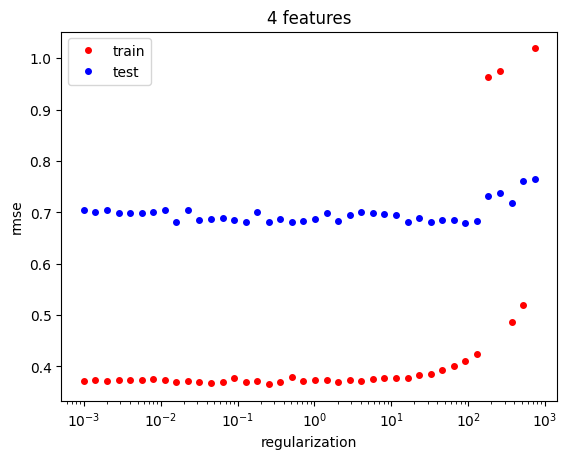

In [249]:

plt.plot(test_loop[0],test_loop[2],'o',ms=4,color='red',label="train")  
plt.plot(test_loop[0],test_loop[3],'o',ms=4,color='blue',label="test")  
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("rmse")
plt.xscale("log")
plt.title("4 features")

Really many needed for stability that is better with constant number of estimators. 

Text(0.5, 1.0, '4 features')

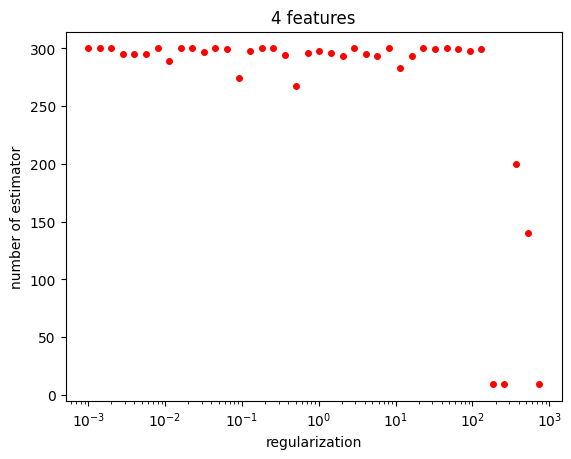

In [250]:

plt.plot(test_loop[0],test_loop[4],'o',ms=4,color='red',label="train")  
#plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("number of estimator")
plt.xscale("log")
plt.title("4 features")

Text(0.5, 1.0, '4 features')

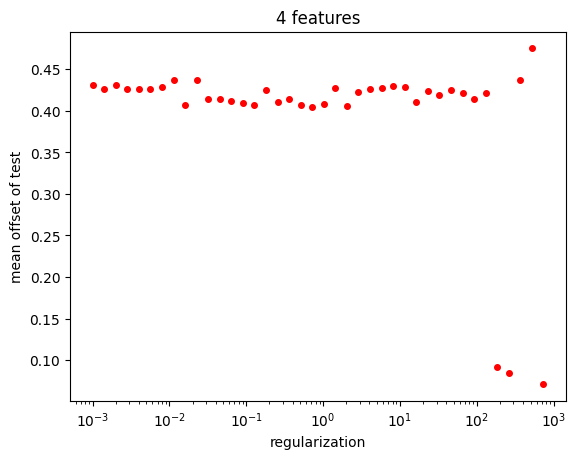

In [251]:

plt.plot(test_loop[0],test_loop[5],'o',ms=4,color='red',label="train")  
#plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("mean offset of test")
plt.xscale("log")
plt.title("4 features")

Offset cases problems in the convergence at the end, but since not bets model not important. 

Looking in prediction offset. 

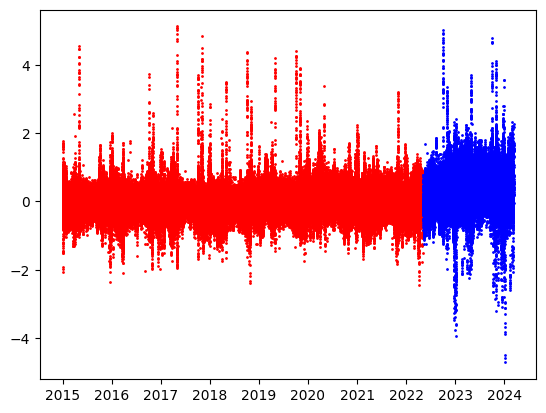

In [252]:
#print(ser_train)
#y_pred2 = model2.predict(x_test2)
#print((y_test2-y_pred2).describe())

#y_pred2b = model2.predict(x_train2)
plt.plot(ser_train.date_time,y_pred2b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred2-y_test,'o',ms=1,color='blue',label="test")  

Seems to be genral offset not extreme event, affected most, likely Ukraine war related, also some general trend. 

(19417.0, 19518.0)

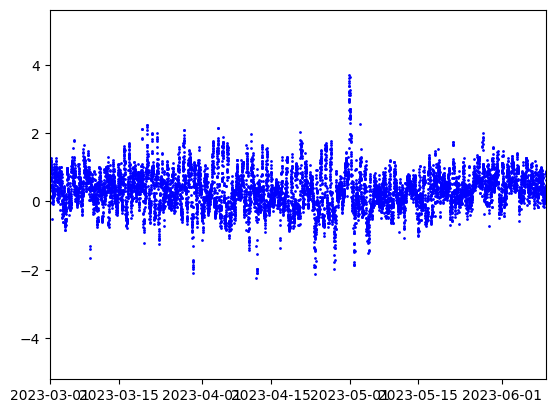

In [254]:
plt.plot(ser_train.date_time,y_pred2b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred2-y_test,'o',ms=1,color='blue',label="test")  
plt.xlim(datetime(2023,3,1),datetime(2023,6,10))

(19518.0, 19754.0)

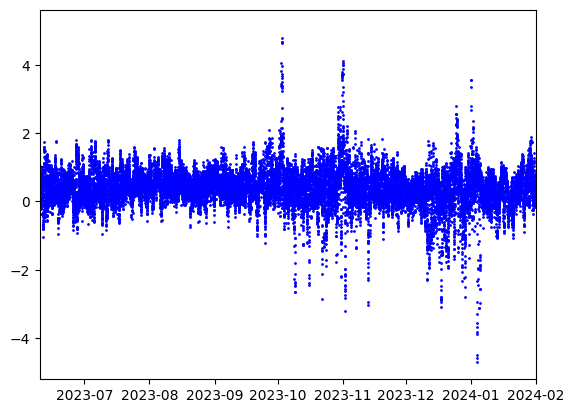

In [253]:
plt.plot(ser_train.date_time,y_pred2b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred2-y_test,'o',ms=1,color='blue',label="test")  
plt.xlim(datetime(2023,6,10),datetime(2024,2,1))

Predictions for easter does only work when delta march is not included. Now just March. 

In [200]:
x_train3=ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_train3=ser_train.loc[:,'to_predict']
x_test3=ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_test3=ser_test.loc[:,'to_predict']
model3 = XGBRegressor(n_estimators=300)
eval_set3 = [(x_test3, y_test3)]

In [201]:
model3.fit(x_train3, y_train3,early_stopping_rounds=100, eval_metric="rmse", eval_set=eval_set3, verbose=True)

[0]	validation_0-rmse:8.88175
[1]	validation_0-rmse:6.07978


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:4.10530
[3]	validation_0-rmse:2.72160
[4]	validation_0-rmse:1.82375
[5]	validation_0-rmse:1.20656
[6]	validation_0-rmse:0.85639
[7]	validation_0-rmse:0.68969
[8]	validation_0-rmse:0.64654
[9]	validation_0-rmse:0.65988
[10]	validation_0-rmse:0.69111
[11]	validation_0-rmse:0.71903
[12]	validation_0-rmse:0.73730
[13]	validation_0-rmse:0.75412
[14]	validation_0-rmse:0.76356
[15]	validation_0-rmse:0.77121
[16]	validation_0-rmse:0.77514
[17]	validation_0-rmse:0.77759
[18]	validation_0-rmse:0.77749
[19]	validation_0-rmse:0.77443
[20]	validation_0-rmse:0.77413
[21]	validation_0-rmse:0.77109
[22]	validation_0-rmse:0.77032
[23]	validation_0-rmse:0.76816
[24]	validation_0-rmse:0.76663
[25]	validation_0-rmse:0.76490
[26]	validation_0-rmse:0.76384
[27]	validation_0-rmse:0.76220
[28]	validation_0-rmse:0.76168
[29]	validation_0-rmse:0.75619
[30]	validation_0-rmse:0.75526
[31]	validation_0-rmse:0.75322
[32]	validation_0-rmse:0.75145
[33]	validation_0-rmse:0.74650
[34]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [208]:

y_pred3 = model3.predict(x_test3)
print((y_test3-y_pred3).describe())

y_pred3b = model3.predict(x_train3)
print((y_train3-y_pred3b).describe())

count    64457.000000
mean        -0.022965
std          0.646134
min         -4.841872
25%         -0.419951
50%         -0.013004
75%          0.396707
max          3.988072
Name: to_predict, dtype: float64
count    257824.000000
mean          0.557789
std           0.603494
min          -5.334740
25%           0.228068
50%           0.570267
75%           0.923878
max           3.578769
Name: to_predict, dtype: float64


(19417.0, 19518.0)

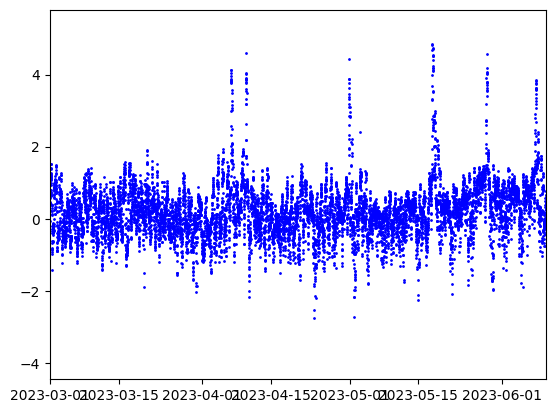

In [217]:
plt.plot(ser_train.date_time,y_pred3b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred3-y_test,'o',ms=1,color='blue',label="test")  
plt.xlim(datetime(2023,3,1),datetime(2023,6,10))

Less good in spring as expected. Frac_year has also problems around holidays. Because does not use exactly a year. 

(19518.0, 19754.0)

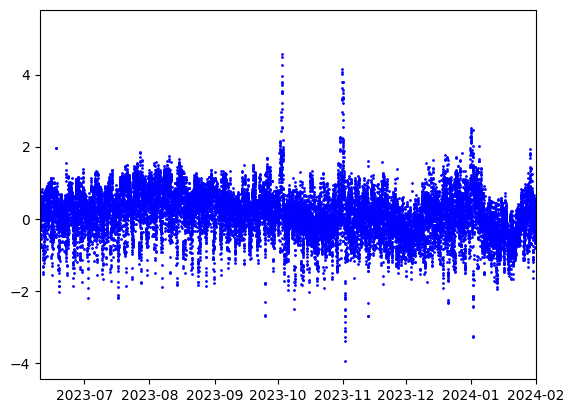

In [216]:
plt.plot(ser_train.date_time,y_pred3b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred3-y_test,'o',ms=1,color='blue',label="test")  
plt.xlim(datetime(2023,6,10),datetime(2024,2,1))

In [206]:
x_train4=ser_train.loc[:,['now','frac_day', 'frac_week', 'delta_march']]
y_train4=ser_train.loc[:,'to_predict']
x_test4=ser_test.loc[:,['now','frac_day', 'frac_week', 'delta_march']]
y_test4=ser_test.loc[:,'to_predict']
model4 = XGBRegressor(n_estimators=300)
eval_set4 = [(x_test4, y_test4)]
model4.fit(x_train4, y_train4,early_stopping_rounds=100, eval_metric="rmse", eval_set=eval_set4, verbose=True)

[0]	validation_0-rmse:8.90923
[1]	validation_0-rmse:6.06373


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:4.07720
[3]	validation_0-rmse:2.73900
[4]	validation_0-rmse:1.80757
[5]	validation_0-rmse:1.22235
[6]	validation_0-rmse:0.85253
[7]	validation_0-rmse:0.67917
[8]	validation_0-rmse:0.63407
[9]	validation_0-rmse:0.64979
[10]	validation_0-rmse:0.68266
[11]	validation_0-rmse:0.70802
[12]	validation_0-rmse:0.72591
[13]	validation_0-rmse:0.73860
[14]	validation_0-rmse:0.74926
[15]	validation_0-rmse:0.75171
[16]	validation_0-rmse:0.75721
[17]	validation_0-rmse:0.75728
[18]	validation_0-rmse:0.75976
[19]	validation_0-rmse:0.75969
[20]	validation_0-rmse:0.75777
[21]	validation_0-rmse:0.75565
[22]	validation_0-rmse:0.75286
[23]	validation_0-rmse:0.75152
[24]	validation_0-rmse:0.75016
[25]	validation_0-rmse:0.74206
[26]	validation_0-rmse:0.74148
[27]	validation_0-rmse:0.73871
[28]	validation_0-rmse:0.73682
[29]	validation_0-rmse:0.73531
[30]	validation_0-rmse:0.73235
[31]	validation_0-rmse:0.73178
[32]	validation_0-rmse:0.73088
[33]	validation_0-rmse:0.72605
[34]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [209]:

y_pred4 = model4.predict(x_test4)
print((y_test4-y_pred4).describe())

y_pred4b = model4.predict(x_train4)
print((y_train4-y_pred4b).describe())

count    64457.000000
mean        -0.000241
std          0.634079
min         -4.777669
25%         -0.388618
50%          0.010484
75%          0.408134
max          3.961176
Name: to_predict, dtype: float64
count    257824.000000
mean          0.557819
std           0.603695
min          -5.154378
25%           0.229573
50%           0.581782
75%           0.927810
max           3.133992
Name: to_predict, dtype: float64


(19426.0, 19509.0)

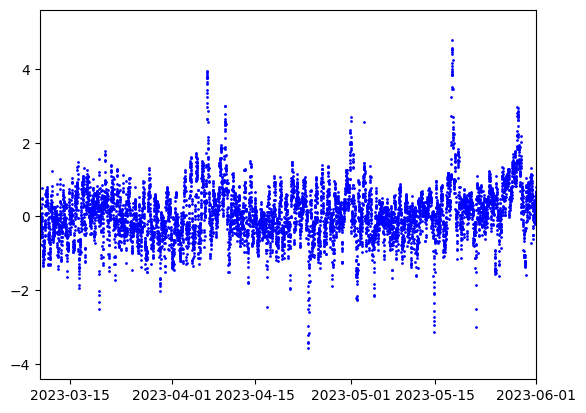

In [218]:
plt.plot(ser_train.date_time,y_pred4b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred4-y_test,'o',ms=1,color='blue',label="test")  
plt.xlim(datetime(2023,3,10),datetime(2023,6,1))

(19518.0, 19754.0)

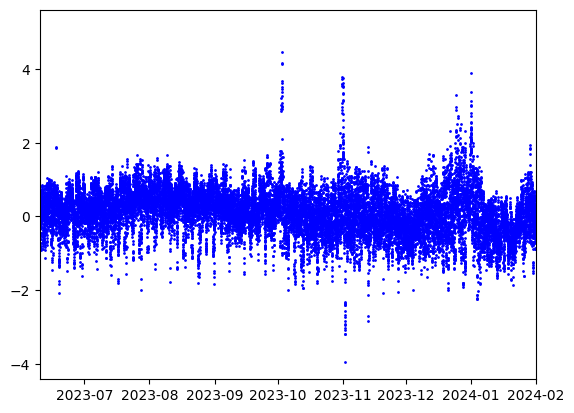

In [219]:
plt.plot(ser_train.date_time,y_pred4b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred4-y_test,'o',ms=1,color='blue',label="test")  
plt.xlim(datetime(2023,6,10),datetime(2024,2,1))

Still problems around holidays, normal sparse data effect?

In [238]:
print(ser_train.iloc[26400:26410,:])
print(ser_test.iloc[14100:14110,:])

          now  to_predict  frac_day  frac_week  frac_year  delta_march  \
26400  10.893      12.582  0.000000   0.285714   0.752909          216   
26401  10.763      12.627  0.010417   0.287202   0.752937          216   
26402  10.632      12.700  0.020833   0.288690   0.752966          216   
26403  10.584      12.569  0.031250   0.290179   0.752995          216   
26404  10.481      12.536  0.041667   0.291667   0.753023          216   
26405  10.394      12.405  0.052083   0.293155   0.753052          216   
26406  10.390      12.294  0.062500   0.294643   0.753080          216   
26407  10.327      12.148  0.072917   0.296131   0.753109          216   
26408  10.351      12.003  0.083333   0.297619   0.753137          216   
26409  10.309      11.877  0.093750   0.299107   0.753166          216   

       delta_easter           date_time  
26400           181 2015-10-03 01:00:00  
26401           181 2015-10-03 01:15:00  
26402           181 2015-10-03 01:30:00  
26403           1

In [ ]:
Yes, days are correct, thus is effect of not enough data to model the interaction of holidays and weekends automatically.

In [26]:
#plt.bar(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']].columns, xmodel2.feature_importances_)
#plt.xticks(rotation = 90)
#plt.show()

NameError: name 'xmodel2' is not defined

In [281]:
def find_best2(dat,delta=3):
    min_p=np.argmin(dat[3])
    est=np.zeros((3))
    #print(dat[0,min_p])
    #print(dat[0:4,min_p-delta:min_p+delta])
    if min_p-delta>=0:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,min_p-delta:min_p+delta],dat[3,min_p-delta:min_p+delta],p0=est)
    else:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,0:min_p+delta],dat[3,0:min_p+delta],p0=est)
    #print(val)
    min_p1=10**dev_quat(val[0],val[1],val[2])
    #print(min_p1)
    #print(dat)
    s=np.argmin(np.abs(min_p1-dat[3]))
    #print(s,dat[4,s])
    return min_p1, dat[4,s], s
    

In [262]:
#xmodel3=XGBRegressor(alpha=best_reg).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
#xmodel3.save_model("xgb_model_096.json")


In [263]:
#xmodel4=XGBRegressor()
#xmodel4.load_model("xgb_model_096.json")

Basic works, now making all to a function that it can be produced for a number of time deltas. 
First for single time delta. 

Should give out standard deviation of test at some point also. 

In [378]:
#parameters data frame, gap to wanted prediction
def find_fit_best_reg2(df,gap,now_points=1,features=['frac_day','frac_week'],test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True,rounds=25,estimators=100,silent=False,limit=2,evalued_on="test"):
    print(gap)
    ser=series_to_supervised(df.total_power,now_points,gap)
    #only single now point implemented
    if now_points==1:
        df_ser=pd.DataFrame(ser,columns=['now','to_predict'])
    for i in range(len(features)):
        if features[i]!='now':
            df_ser.loc[:,features[i]]=df.loc[0:df_ser.shape[0],features[i]]
    if 'now' not in features:
        features.append('now')
    if silent==False:
        print(df_ser.columns)
    frac1=int(df_ser.shape[0]*0.8)
    if silent==False:
        print(f"{frac1} rows in train")
    ser_train=df_ser.iloc[:frac1,:]
    ser_test=df_ser.iloc[frac1:,:]
    x_train=ser_train.loc[:,features]
    y_train=ser_train.loc[:,'to_predict']
    x_test=ser_test.loc[:,features]
    y_test=ser_test.loc[:,'to_predict']    
    stat_reg=loop_reg_nest(x_train,y_train,x_test,y_test,silent=silent,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,save=False,regression=True,rounds=rounds,estimators=estimators,limit=limit,evalued_on=evalued_on)
    best_reg, best_nest,s=find_best2(stat_reg,delta=delta)
    if silent==False:
        print(f"best used case has {best_nest} estimators and regularization of {best_reg}")
    #now use again train should better for getting offset correct
    xmodel=XGBRegressor(alpha=best_reg,max_depth=max_depth,n_estimators=int(best_nest)).fit(x_train,y_train)
    test_pred=xmodel.predict(x_test)
    test_std=np.std(y_test-test_pred)
    test_offset=np.mean(y_test-test_pred)
    if silent==False:
        print(f"final model has std={test_std} and mean offset of {test_offset} on test")
    if save==True:
        xmodel.save_model(filename)
        return test_std,test_offset
    else:
        return xmodel, test_std, test_offset

Test fit. 

In [274]:
test_st,test_off=find_fit_best_reg2(comb_real_power,1,reg_steps=4,rounds=25,filename="xgb2_model_001.json")

1
Index(['now', 'to_predict', 'frac_day', 'frac_week'], dtype='object')
257856 rows in train
doing case 0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 100
mean of test 0.0126 points
mean of train 0.0 points
rsme of test 0.1565 points
rsme of train 0.143 points
xgb took 0:00:02.969906 seconds
doing case 1
best n_estimator is 100
mean of test 0.0107 points
mean of train 0.0 points
rsme of test 0.1557 points
rsme of train 0.1437 points
xgb took 0:00:03.311241 seconds
doing case 2
best n_estimator is 87
mean of test 0.0112 points
mean of train -0.0 points
rsme of test 0.1565 points
rsme of train 0.1452 points
xgb took 0:00:02.556163 seconds
doing case 3
best n_estimator is 96
mean of test 0.0124 points
mean of train -0.0 points
rsme of test 0.1584 points
rsme of train 0.1444 points
xgb took 0:00:02.706269 seconds
0.001414
[[1.41400000e-03 1.99939600e-03 2.82714594e-03]
 [4.00000000e+00 4.00000000e+00 4.00000000e+00]
 [1.43734843e-01 1.45222975e-01 1.44376543e-01]
 [1.55732030e-01 1.56456158e-01 1.58427325e-01]]
[0.40367495 0.1743534  0.03065641]
0.0014332772150471513
[[1.00000000e-03 1.41400000e-03 1.99939600e-03 2.82

In [275]:
print(test_st)
print(test_off)
print(np.mean(y_test))

0.15536118137616525
-0.010741092668747778
13.288245772375383


Seems to work. 

Make function to many of them. but is only run when also better feature for year are ready, not enough progress otherwise.

In [379]:
def fit_many_gaps2(df,features=['frac_day','frac_week'],base_name='xgb2_model',gap_start=1,gap_steps=2,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True,rounds=25,estimators=100,limit=2,silent=False,evalued_on="test"):
    results=np.zeros((3,gap_steps))
    for i in range(gap_steps):
        gap=gap_start+i
        print(gap)
        if gap<10:
            filename=base_name+"_00"+str(gap)+".json"
        elif gap<100:
            filename=base_name+"_0"+str(gap)+".json"
        elif gap<1000:
            filename=base_name+"_"+str(gap)+".json"            
        std,offset=find_fit_best_reg2(df,gap,features=features,now_points=now_points,test_frac=test_frac,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,delta=delta,filename=filename,save=True,rounds=rounds,estimators=estimators,limit=limit,silent=silent,evalued_on=evalued_on)
        results[0,i]=gap
        results[1,i]=std
        results[2,i]=offset 
        #was i at end name at the begnning instead of gap 
        end_name=str(gap_start)+"_"+str(gap)+".txt"
        np.savetxt(base_name+end_name,results[:,:i+1])
    return results    

In [380]:
# redo from 101 onwards next night
rsme_results=fit_many_gaps2(comb_real_power,features=['frac_day','frac_week','delta_easter'],base_name='xgb2e_model',reg_steps=40,reg_start=0.0010,gap_start=105,gap_steps=1,rounds=100,limit=2,evalued_on="train")

105
105
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'delta_easter'], dtype='object')
257772 rows in train
doing case 0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 100
mean of test 0.456 points
mean of train 0.0 points
rsme of test 0.7475 points
rsme of train 0.5214 points
xgb took 0:00:03.165377 seconds
doing case 1
best n_estimator is 100
mean of test 0.456 points
mean of train 0.0 points
rsme of test 0.7475 points
rsme of train 0.5214 points
xgb took 0:00:03.610424 seconds
doing case 2
best n_estimator is 100
mean of test 0.456 points
mean of train 0.0 points
rsme of test 0.7475 points
rsme of train 0.5214 points
xgb took 0:00:02.857836 seconds
doing case 3
best n_estimator is 100
mean of test 0.456 points
mean of train 0.0 points
rsme of test 0.7475 points
rsme of train 0.5214 points
xgb took 0:00:03.766302 seconds
doing case 4
best n_estimator is 100
mean of test 0.456 points
mean of train 0.0 points
rsme of test 0.7475 points
rsme of train 0.5214 points
xgb took 0:00:03.647154 seconds
doing case 5
best n_estimator is 100
mean of test 0.456 points
mean of train 0.0 points
rsme of test 0.7475 points
rsme of train 0.5214 po

Now usually 100 estimators, is the maximum possible without parameter change. (The changes seem more often cause problems, than the opposite). 

[[ 5.90000000e+01  5.88591949e-01 -4.66110783e-01]
 [ 6.00000000e+01  5.90523118e-01 -4.63837354e-01]
 [ 6.10000000e+01  5.96140489e-01 -4.70076825e-01]
 [ 6.20000000e+01  6.02385497e-01 -4.65492065e-01]
 [ 6.30000000e+01  5.94489769e-01 -4.72083442e-01]
 [ 6.40000000e+01  5.97550897e-01 -4.75531964e-01]
 [ 6.50000000e+01  6.04131805e-01 -4.73424719e-01]
 [ 6.60000000e+01  6.05863591e-01 -4.73014749e-01]
 [ 6.70000000e+01  5.85756692e-01 -4.68535381e-01]
 [ 6.80000000e+01  5.94815126e-01 -4.76187437e-01]
 [ 6.90000000e+01  5.96386130e-01 -4.81142479e-01]
 [ 7.00000000e+01  6.07172504e-01 -4.65947193e-01]
 [ 7.10000000e+01  5.97531832e-01 -4.81209988e-01]
 [ 7.20000000e+01  5.96097987e-01 -4.70396947e-01]
 [ 7.30000000e+01  5.95962940e-01 -4.63301876e-01]
 [ 7.40000000e+01  5.98319838e-01 -4.68991901e-01]
 [ 7.50000000e+01  5.97245865e-01 -4.65910184e-01]
 [ 7.60000000e+01  5.92849388e-01 -4.58998957e-01]
 [ 7.70000000e+01  5.94175589e-01 -4.67576541e-01]
 [ 7.80000000e+01  5.89388876e-

Text(0, 0.5, 'measure [%]')

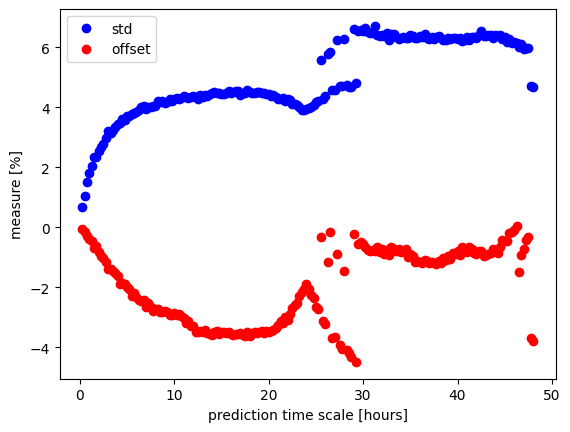

In [374]:
av=np.mean(ser_test.to_predict)
r1=np.loadtxt("xgb2e_model0_2.txt")
r2=np.loadtxt("xgb2e_model3_9.txt")
r3=np.loadtxt("xgb2e_model13_4.txt")
r4=np.loadtxt("xgb2e_model18_26.txt")
r5=np.loadtxt("xgb2e_model27_29.txt")
r6=np.loadtxt("xgb2e_model30_58.txt")
#one bad redone with 20% more 
r6b=np.loadtxt("xgb2e_model37_37.txt")
r6[:,7]=r6b
r7=np.loadtxt("xgb2e_model59_191.txt")
print(r7.T)

plt.plot(r1[0]*0.25+0.25,r1[1]/av*100,'o',color='blue',label='std')
plt.plot(r1[0]*0.25+0.25,r1[2]/av*100,'o',color='red',label='offset')
plt.plot(r2[0]*0.25+0.25,r2[1]/av*100,'o',color='blue')
plt.plot(r2[0]*0.25+0.25,r2[2]/av*100,'o',color='red')
plt.plot(r3[0]*0.25+0.25,r3[1]/av*100,'o',color='blue')
plt.plot(r3[0]*0.25+0.25,r3[2]/av*100,'o',color='red')
plt.plot(r4[0]*0.25+0.25,r4[1]/av*100,'o',color='blue')
plt.plot(r4[0]*0.25+0.25,r4[2]/av*100,'o',color='red')
plt.plot(r5[0]*0.25+0.25,r5[1]/av*100,'o',color='blue')
plt.plot(r5[0]*0.25+0.25,r5[2]/av*100,'o',color='red')
plt.plot(r6[0]*0.25+0.25,r6[1]/av*100,'o',color='blue')
plt.plot(r6[0]*0.25+0.25,r6[2]/av*100,'o',color='red')
plt.plot(r7[0]*0.25+0.25,r7[1]/av*100,'o',color='blue')
plt.plot(r7[0]*0.25+0.25,r7[2]/av*100,'o',color='red')
#plt.plot(r2[0]*15+15,r2[1]/av*100,'o',color='red')
#plt.plot(r3[0]*15+15,r3[1]/av*100,'o',color='green')
plt.legend()
plt.xlabel("prediction time scale [hours]")
plt.ylabel("measure [%]")

Mostly fine, but choosing converged one is not easy, problem partly caused by the offset between test and train. 
Clearly not ideal for training the offset, that way the offset is possible also miniziwd althought that is not neededed, since it can be just corrected after the fact.  

Many on the less offset for scatter solution at 101 at larger. 

About a day predictions are better than ~half a day, that fact can be used for prediction imporvements.

## Further improvement ideas
- Add more past (possible average) data points
- Summarize some holidays to make it easier to model them

In prediction dependent dat the easter or day prediction should be used. 

In [356]:
#prediction function
#parameters, most recent features, list of model,delta ts, standard is just every 0.25 h from models
def predict_from_now2(data,errors,models,deltas=None):
    print(data)
    if deltas==None:
        deltas=np.zeros((len(models)))
        for i in range(len(models)):
            deltas[i]=0.25+i/4
    res=np.zeros((3,len(models)))  
    res[0,:]=deltas
    for i in range(len(models)):
        print(i)
        xmodel=XGBRegressor()
        xmodel.load_model(models[i])
        #predict needs more than 1 data point to work, offset corrected  
        res[1,i]=xmodel.predict(data)[-1]+errors[2,i]
        #now insert error
        res[2,i]=errors[1,i]
    #need better column names at some points in a data frame     
    return res     

In [357]:
myPath='/home/tobias/ml-testing/energy/energy-timeseries'
models=[f for f in os.listdir(myPath) 
    if (f.startswith('xgb2e_model_')) and  (f.endswith('json') )] 
models.sort()
print(models)

['xgb2e_model_000.json', 'xgb2e_model_001.json', 'xgb2e_model_002.json', 'xgb2e_model_003.json', 'xgb2e_model_004.json', 'xgb2e_model_005.json', 'xgb2e_model_006.json', 'xgb2e_model_007.json', 'xgb2e_model_008.json', 'xgb2e_model_009.json', 'xgb2e_model_010.json', 'xgb2e_model_011.json', 'xgb2e_model_012.json', 'xgb2e_model_013.json', 'xgb2e_model_014.json', 'xgb2e_model_015.json', 'xgb2e_model_016.json', 'xgb2e_model_017.json', 'xgb2e_model_018.json', 'xgb2e_model_019.json', 'xgb2e_model_020.json', 'xgb2e_model_021.json', 'xgb2e_model_022.json', 'xgb2e_model_023.json', 'xgb2e_model_024.json', 'xgb2e_model_025.json', 'xgb2e_model_026.json', 'xgb2e_model_027.json', 'xgb2e_model_028.json', 'xgb2e_model_029.json', 'xgb2e_model_030.json', 'xgb2e_model_031.json', 'xgb2e_model_032.json', 'xgb2e_model_033.json', 'xgb2e_model_034.json', 'xgb2e_model_035.json', 'xgb2e_model_036.json', 'xgb2e_model_037.json', 'xgb2e_model_038.json', 'xgb2e_model_039.json', 'xgb2e_model_040.json', 'xgb2e_model_04

In [360]:
errors=np.concatenate((r1.T,r2.T,r3.T,r4.T,r5.T,r6.T)).T
print(errors.shape)

(3, 59)


In [361]:
prediction=predict_from_now2(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0],['frac_day', 'frac_week', 'delta_easter','total_power']],errors,models[:])

        frac_day  frac_week  delta_easter  total_power
322319  0.489583   0.641369           -20     16.24175
322320  0.500000   0.642857           -20     15.99775
322321  0.510417   0.644345           -20     15.88125
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


In [362]:
prediction1m=predict_from_now2(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0]-2,['frac_day', 'frac_week', 'delta_easter','total_power']],errors,models[:])

        frac_day  frac_week  delta_easter  total_power
322319  0.489583   0.641369           -20     16.24175
322320  0.500000   0.642857           -20     15.99775
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


In [307]:
models_old=[f for f in os.listdir(myPath) 
    if (f.startswith('xgb_model_')) and  (f.endswith('json') )] 
models_old.sort()
print(models_old)

['xgb_model_000.json', 'xgb_model_001.json', 'xgb_model_002.json', 'xgb_model_003.json', 'xgb_model_004.json', 'xgb_model_005.json', 'xgb_model_006.json', 'xgb_model_007.json', 'xgb_model_008.json', 'xgb_model_009.json', 'xgb_model_010.json', 'xgb_model_011.json', 'xgb_model_012.json', 'xgb_model_013.json', 'xgb_model_014.json', 'xgb_model_015.json', 'xgb_model_016.json', 'xgb_model_017.json', 'xgb_model_018.json', 'xgb_model_019.json', 'xgb_model_020.json', 'xgb_model_021.json', 'xgb_model_022.json', 'xgb_model_023.json', 'xgb_model_024.json', 'xgb_model_025.json', 'xgb_model_026.json', 'xgb_model_027.json', 'xgb_model_028.json', 'xgb_model_029.json', 'xgb_model_030.json', 'xgb_model_031.json', 'xgb_model_032.json', 'xgb_model_033.json', 'xgb_model_034.json', 'xgb_model_035.json', 'xgb_model_036.json', 'xgb_model_037.json', 'xgb_model_038.json', 'xgb_model_039.json', 'xgb_model_040.json', 'xgb_model_041.json', 'xgb_model_042.json', 'xgb_model_043.json', 'xgb_model_044.json', 'xgb_mode

In [311]:
#parameters, most recent features, list of model,delta ts, standard is just every 0.25 h from models
#ild version before optimized for presenting instead of analysing
def predict_from_now_old(data,models,deltas=None):
    print(data)
    if deltas==None:
        deltas=np.zeros((len(models)))
        for i in range(len(models)):
            deltas[i]=0.25+i/4
    res=np.zeros((3,len(models)))  
    res[0,:]=deltas
    for i in range(len(models)):
        print(i)
        xmodel=XGBRegressor()
        xmodel.load_model(models[i])
        #predict needs more than 1 data point to work 
        res[1,i]=xmodel.predict(data)[-1]
    #need better column names at some points in a data frame     
    return res     

In [312]:
#old function used 
prediction_old=predict_from_now_old(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0],['total_power','frac_day', 'frac_week', 'frac_year']],models_old[:])

        total_power  frac_day  frac_week  frac_year
322319     16.24175  0.489583   0.641369   0.192305
322320     15.99775  0.500000   0.642857   0.192334
322321     15.88125  0.510417   0.644345   0.192363
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


Seems to work and relatively fast, likely fats enough for doing it every 15 mimnutes.
Not crazy fast but good enough for now. 

(-0.1, 18.0)

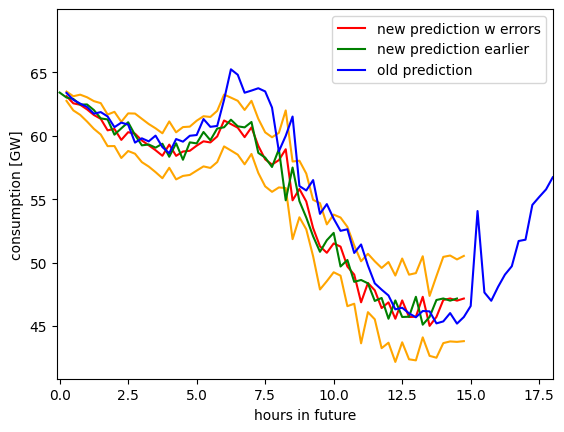

In [364]:
plt.plot(prediction[0],prediction[1]*4,color='red',label='new prediction w errors')
plt.plot(prediction[0],prediction[1]*4+prediction[2]*4,color='orange')
plt.plot(prediction[0],prediction[1]*4-prediction[2]*4,color='orange')
plt.plot(prediction1m[0]-1/4,prediction1m[1]*4,color='green',label='new prediction earlier')
plt.plot(prediction_old[0],prediction_old[1]*4,color='blue',label='old prediction')
plt.legend()
plt.xlabel("hours in future")
plt.ylabel("consumption [GW]")   
plt.xlim(-0.1,18)
#print(prediction[0:2,43:50].T)

Similar looking, a little lower now because of adjustment in trend.  

In [350]:
print(comb_real_power)

                 date_time  total_power  frac_day  frac_week  frac_year  year  \
0      2015-01-01 00:00:00     11.21000  0.000000   0.000000   0.000000  2015   
1      2015-01-01 00:15:00     11.11900  0.010417   0.001488   0.000029  2015   
2      2015-01-01 00:30:00     11.14500  0.020833   0.002976   0.000057  2015   
3      2015-01-01 00:45:00     11.12700  0.031250   0.004464   0.000086  2015   
4      2015-01-01 01:00:00     11.01000  0.041667   0.005952   0.000114  2015   
...                    ...          ...       ...        ...        ...   ...   
322317 2024-03-11 11:15:00     16.37900  0.468750   0.638393   0.192248  2024   
322318 2024-03-11 11:30:00     16.34550  0.479167   0.639881   0.192277  2024   
322319 2024-03-11 11:45:00     16.24175  0.489583   0.641369   0.192305  2024   
322320 2024-03-11 12:00:00     15.99775  0.500000   0.642857   0.192334  2024   
322321 2024-03-11 12:15:00     15.88125  0.510417   0.644345   0.192363  2024   

        month  delta_easter